## Post-process a finetuned LLM

Test and upload a finetuned language model

## Setup

In [1]:
import transformers
import torch
import tensorflow as tf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!nvidia-smi

Wed Jul  5 10:05:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA H100 PCIe    On   | 00000000:06:00.0 Off |                    0 |
| N/A   41C    P0    50W / 350W |      3MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '76GB'}


## Loss curve

In [6]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "./results/runs/Jul04_16-19-00_209-20-156-79/events.out.tfevents.1688487599.209-20-156-79.36094.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == "train/loss":
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

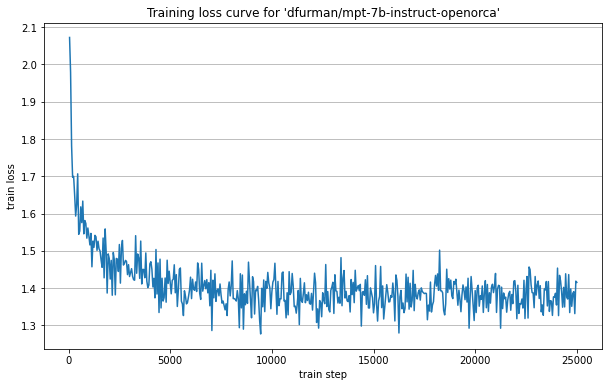

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss)
plt.title("Training loss curve for 'dfurman/mpt-7b-instruct-openorca'")
plt.ylabel("train loss")
plt.xlabel("train step")
plt.grid(which="major", axis="y")
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [8]:
# load assets

model_id = "./results/checkpoint-25000"
# model_id = "dfurman/mpt-7b-instruct-reproduced"

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
config.attn_config[
    "attn_impl"
] = "triton"  # Optional triton attention for improved latency
config.init_device = "meta"  # For fast initialization directly on GPU!
# config.max_seq_len = 4096 # (input + output) tokens can now be up to 4096
config.torch_dtype = "bfloat16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

config

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Instantiating an MPTForCausalLM model from /home/ubuntu/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/72e5f594ce36f9cabfa2a9fd8f58b491eb467ee7/modeling_mpt.py


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "./results/checkpoint-25000",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "triton",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "meta",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_len

## Basic instruction tests

In [9]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Falcon model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate. Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.bfloat16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [10]:
prompt = "You are a helpful assistant. Write me a numbered list of things to do in New York City.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


1. Visit the Statue of Liberty: The Statue of Liberty is a symbol of freedom and democracy, and it is a must-see attraction in New York City.
2. Visit the Empire State Building: The Empire State Building is a famous skyscraper in New York City, offering panoramic views of the city.
3. Visit the Metropolitan Museum of Art: The Metropolitan Museum of Art is one of the largest and most famous art museums in the world, housing a vast collection of artworks.
4. Visit the Museum of Modern Art: The Museum of Modern Art is another world-renowned art museum in New York City, showcasing modern and contemporary art.
5. Visit the 9/11 Memorial and Museum: The 9/11 Memorial and Museum is a somber but important attraction in New York City, commemorating the tragic events of September 11, 2001.
6. Visit the Central Park: Central Park is a massive urban park in the heart of New York City, offering a variety of activities and attractions, including the iconic Central Park Zoo.
7. Visit the Rockefeller 

In [11]:
prompt = "You are a helpful assistant. Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense? Let's work this out in a step by step fashion to make sure we have the right answer.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)


Step 1: Determine the days of the week that the barber works.
The barber works Mondays, Wednesdays, and Fridays.

Step 2: Determine the day of the week that Daniel went in for a haircut.
Daniel went in for a haircut on Sunday.

Step 3: Compare the day of the week that Daniel went in for a haircut to the days the barber works.
Sunday is not one of the days the barber works.

Step 4: Determine if the statement makes logical sense.
The statement does not make logical sense because Daniel went in for a haircut on a day the barber does not work.

Answer: No, the statement does not make logical sense. Daniel should have gone in for a haircut on a day the barber works, such as Monday, Wednesday, or Friday.

In conclusion, the statement "Daniel went in for a haircut on Sunday" does not make logical sense because Sunday is not one of the days the barber works. Daniel should have gone in for a haircut on a day the barber works, such as Monday, Wednesday, or Friday. Therefore, the answer is "No,

In [12]:
prompt = "You are a helpful assistant. Write a short email inviting my friends to a dinner party on Friday. Respond succinctly.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=200,
    temperature=0.92,
)

print(response)

Subject: Invitation to Friday Dinner Party

Dear Friend,

I hope this email finds you well. I am writing to invite you to a dinner party that I am hosting on Friday. The party will be a casual gathering, and I would love to have you join us.

The dinner will be held at my home, and the time is from 7:00 pm to 10:00 pm. The address is 123 Main Street, San Francisco, CA 94122.

The dinner will be a potluck, so please bring a dish to share. I will provide the main course, so you can focus on bringing a side dish or dessert.

Please RSVP by replying to this email or by calling me at 555-555-5555. I look forward to seeing you on Friday!

Yours,

Your Friendly Assistant

[Your name]

[Your email address]

[Your phone number]



## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [13]:
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
!git config --global credential.helper store

In [17]:
# push to hub
model_id_load = "dfurman/mpt-7b-instruct-orca"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-orca/commit/0ddc2f82f7b9144bb9b8c608e0432074c54a6de7', commit_message='Upload tokenizer', commit_description='', oid='0ddc2f82f7b9144bb9b8c608e0432074c54a6de7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)